# Training und Verifikation mittels MILP von Netz auf CIFAR10 Datensatz
Es sollte bereits ein trainiertes Netz existieren.

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.Networks import *
from script.NeuralNets.trainFunction import train_sequential
from script.Verification.Verifier import MILPVerifier, SingleNeuronVerifier
import time
from jupyterthemes import jtplot
import gurobipy as grp
from gurobipy import GRB, max_
import script.Verification.VerificationBasics as verbas

load_model = True
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)



In [2]:
transform = Compose([ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                    )

training_data = CIFAR10(root="../../cifar",
                        train=True,
                        download=True,
                        transform=transform)

test_data = CIFAR10(root="../../cifar",
                    train=False,  # test set, 10k images
                    download=True,
                    transform=transform)

batch_size = 4
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True)

classes = training_data.classes


def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"""model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
model.load_state_dict(torch.load("../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
"""

model = SequentialNN([32 * 32 * 3, 1024, 512, 10])

if load_model:
    model.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device('cpu')), strict=False)
else:
    train_sequential(model, train_dataloader, test_dataloader, epochs=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


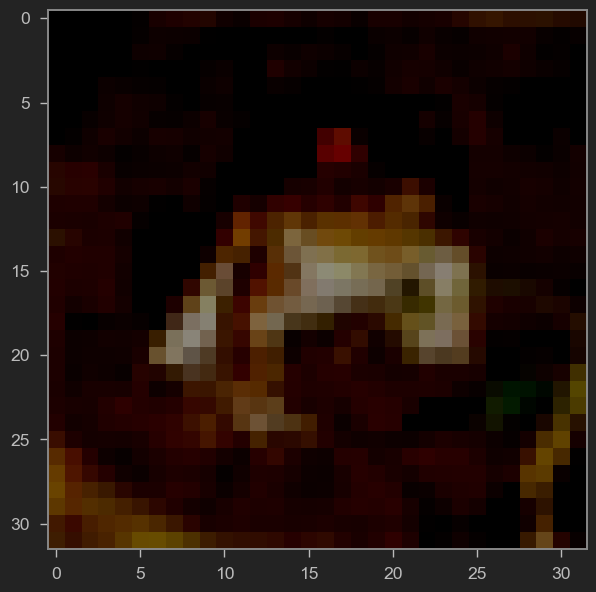

label is frog with index 6
prediction is frog with output tensor([[ 1.3665, -0.5882,  0.1332,  1.2625,  1.8794,  0.4330,  3.5173,  0.8659,
         -5.1264, -2.9051]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


In [4]:
images, labels = training_data.__getitem__(0)
testimage, testlabel = torch.unsqueeze(images, 0).to(torch.float64), torch.unsqueeze(torch.tensor(labels), 0).to(torch.float64)
imshow(images)
print("label is {} with index {}".format(classes[labels], labels))
pred = model(testimage)

print("prediction is {} with output {} ".format(classes[pred.argmax()], pred))

Set parameter BestObjStop to value 0.001
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 11537 rows, 6164 columns and 3689162 nonzeros
Model fingerprint: 0x5d2982c3
Model has 1 general constraint
Variable types: 6164 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-11, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-04, 1e+02]
  RHS range        [3e-05, 2e+00]
Presolve removed 7886 rows and 592 columns
Presolve time: 4.18s
Presolved: 3651 rows, 5572 columns, 2906571 nonzeros
Variable types: 5563 continuous, 9 integer (9 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     190    1.2916713e+02   1.412550e+02   0.000000e+00      5s
    1045    1.2916727e+02   0.000000e+00   0.000000e+00      6s

Root relax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23.435598400686246
18.44015153929766
19.121866904084925
17.934319553717216
23.004505412683827
19.895355257141503
43.1639788095075
10.598708082452163
19.70561159579708
optimum solution with value 
 [ 4.32061571e+00 -6.74831149e-01  6.88421576e-03 -1.18066313e+00
  3.88952272e+00  7.80372569e-01 -1.91149827e+01  2.40489961e+01
 -8.51627461e+00  5.90628907e-01]
max_var 43.1639788095075

time to solve 23.92186665534973 s.
tensor([[-0.5523, -0.6777, -0.6228,  ...,  0.0830, -0.3562, -0.4503]],
       dtype=torch.float64)
prediction is frog with output tensor([[ 1.5479, -0.6750,  0.0111,  0.9762,  2.0773,  0.4362,  2.3863,  2.0450,
         -5.1892, -2.7633]], dtype=torch.float64, grad_fn=<AddmmBackward0>) 


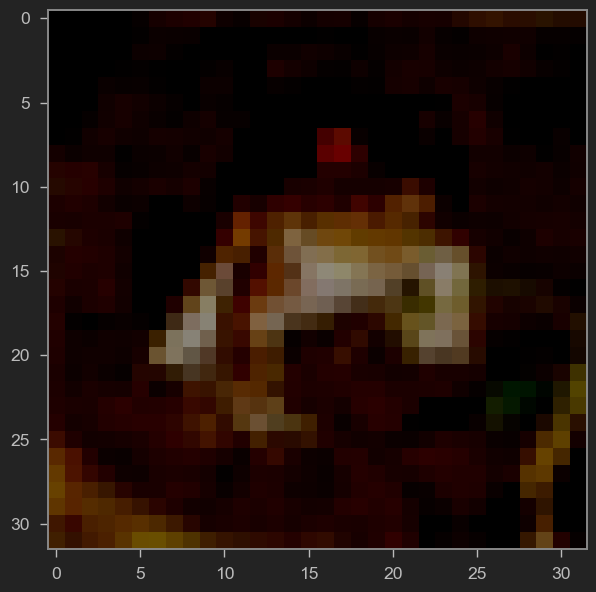

In [6]:
print("=================")
start = time.time()
eps = 0.015
flattened_img = torch.flatten(testimage)
in_var_bounds = [flattened_img.add(-eps), flattened_img.add(eps)]
bounds_affine_out, bounds_layer_out = model.calculate_box_bounds(in_var_bounds)

out_lb= bounds_layer_out[-1][0]
out_ub= bounds_layer_out[-1][1]
difference_lb = out_lb - out_ub[labels]
difference_ub = out_ub - out_lb[labels]
difference_lb = difference_lb.tolist()
difference_ub = difference_ub.tolist()
difference_lb.pop(labels)
difference_ub.pop(labels)
min_diff = min(difference_lb)
max_diff = max(difference_ub)

#verifier = MILPVerifier(model, testimage, eps, solver_bound=0.001, print_log=True)
verifier = SingleNeuronVerifier(model, testimage, eps, solver_bound=0.001, print_log=True)
verifier.generate_constraints_for_net()
output_var = verifier.output_vars
m = verifier.model
input_var = verifier.input_vars

difference = m.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
#difference = m.addVars(9, lb=-30, ub=30, name="diff_var")
m.addConstrs((difference[i] == output_var.tolist()[i] - output_var.tolist()[labels] for i in range(0, labels)), name="diff_const0")
m.addConstrs((difference[i - 1] == output_var.tolist()[i] - output_var.tolist()[labels] for i in range(labels + 1, 10)), name="diff_const1")

max_var = m.addVar(lb=min_diff, ub=max_diff, name="max_var")
m.addConstr(max_var == max_(difference))

m.update()
m.setObjective(max_var, GRB.MAXIMIZE)
m.optimize()

"""m.computeIIS()
print("constraint")
all_constr = m.getConstrs()

for const in all_constr:
    if const.IISConstr:
        print("{}".format(const))

print("lower bound")
all_var = m.getVars()
for var in all_var:
    if var.IISLB:
        print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

print("upper bound")
all_var = m.getVars()
for var in all_var:
    if var.IISUB:
        print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))"""

alt_pic, alt_out = None, None
inp = None
if m.Status == GRB.OPTIMAL or m.Status == GRB.TIME_LIMIT or m.Status == GRB.USER_OBJ_LIMIT:
    inp = input_var.getAttr("x")
    for o in difference.select():
        print(o.getAttr("x"))
    print("optimum solution with value \n {}".format(output_var.getAttr("x")))
    print("max_var {}".format(max_var.getAttr("x")))
    test_inp = torch.tensor([inp], dtype=torch.float64)
    alt_pic, alt_out =  test_inp, output_var


end = time.time() - start
print("=================")
print("")
print("time to solve {} s.".format(end))
if alt_pic is not None:
    print(alt_pic)
    out = model(alt_pic)
    print("prediction is {} with output {} ".format(classes[out.argmax()], out))

    reshaped = np.reshape(alt_pic, (3, 32, 32))
    imshow(reshaped)